In [1]:
import mcba
mcba.__file__

'/home/br/sweethome/1Dimpur/mcba_sandbox/mcba/__init__.py'

In [2]:
!echo $PYTHONPATH

/home/br/sweethome/1Dimpur/mcba_sandbox


In [2]:
%matplotlib notebook

import numpy as np
import scipy.linalg as linalg
import matplotlib.pyplot as plt

import pandas as pd

# Run the walker / load the DB

In [15]:
from mcba.walker import Walker
from mcba.models.impurity import Par, SingleImpurity
from mcba.models.impurity import gamma, initial_q, k_F, E_FS, E_F, E_in, energy

In [4]:
from mcba.walker import Walker
from mcba.models.impurity import Par, SingleImpurity
from mcba.models.impurity import gamma, initial_q, k_F, E_FS, E_in, energy

par = Par(N=7, L=21, m_q=5)
model = SingleImpurity(par)

#run MC
walker = Walker(model, db_fname='N7.sqlite') 
walker.walk()

reading the DB...
...done
checking  fsPairs(h=[-4, -3], p=[-6, 7])  ...ok
checking  fsPairs(h=[-4, 3], p=[-6, 7])  ...ok
checking  fsPairs(h=[-4, -1], p=[-5, 4])  ...ok
checking  fsPairs(h=[-4, 3], p=[-26, 33])  ...ok
checking  fsPairs(h=[-4, 3], p=[-16, 23])  ...ok
checking  fsPairs(h=[-4, -3], p=[-24, 25])  ...ok
checking  fsPairs(h=[-4, 3], p=[-27, 28])  ...ok
checking  fsPairs(h=[-4, -1], p=[-8, 10])  ...ok
checking  fsPairs(h=[-4, 2], p=[-22, 28])  ...ok
checking  fsPairs(h=[1, 3], p=[-16, 22])  ...ok

loading the cache...done. Start w/  271  entries.
nothing to be done for this one, exiting.

 *** checkpointing, do NOT terminate...done

FINALLY,
  total distinct confs:  271
\sum |<FS|fq>|^2 =  0.9959164558514865
\sum  <fq | P_up | fq> =  0.8037518426057967
FINALIZE: done 


 *** checkpointing, do NOT terminate...done

FINALLY,
  total distinct confs:  271
\sum |<FS|fq>|^2 =  0.9959164558514865
\sum  <fq | P_up | fq> =  0.8037518426057967
FINALIZE: done 



In [10]:
import mcba.models.impurity.matrix_elements2 as mx2
import mcba.db as db

In [6]:
#it = filter(lambda x: len(x["partition"].h) == 1, db.row_iterator(handle))

db_fname = './N7.sqlite'
handle, = db.get_handles(db_fname)
par = db.get_param(handle)

lst = list(dict(_) for _ in db.row_iterator(handle))
for x in lst:
    x['energy'] = energy(x, par)

lst_1 = [mx2._preprocess_roots(x, par) for x in lst] 

In [7]:
df = pd.DataFrame(lst)

In [8]:
df["FSfq**2"] = df["FSfq"]**2
df = df.sort_values("FSfq**2", ascending=False)

In [9]:
# check that c=+\infty is not present (double-counting w/-inf)
(df["c"] == float('inf')).sum()

0

In [10]:
E_in(par)

5.463458526001857

<IPython.core.display.Javascript object>


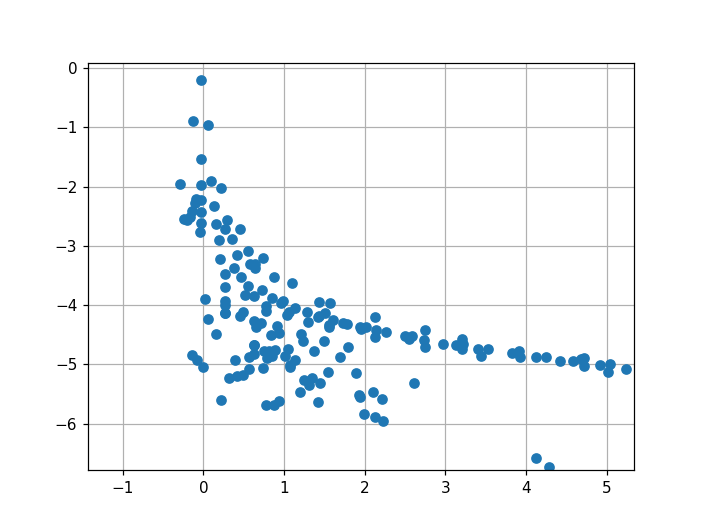

In [11]:
plt.plot((df["energy"] - E_in(par))/E_in(par), np.log10(df["FSfq**2"]), 'o')
plt.grid(True)

In [62]:
df.iloc[0, :].to_dict()

{'FSfq': -0.7916873936865905,
 'FSfq**2': 0.6267689293222665,
 'P': 1.085185531503318,
 'c': 3.7783910852833356,
 'db_key': 0,
 'energy': 5.2742491364416235,
 'partition': fsPairs(h=[3], p=[5]),
 'roots': array([-9.60126449, -6.4800938 , -3.3641312 , -0.25558187,  2.84197079,
         5.92238806,  8.97454999, 17.67012578])}

# Filter only states w/ a single hole --- wrong matrix elements

In [86]:
mask = [len(x.h) == 1 for x in df["partition"].values]

In [87]:
df_1 = df[mask]

In [90]:
num_states = len(df_1)

pmat = np.empty((num_states, num_states), dtype=float)

for i in range(num_states):
    ri = df_1.iloc[i, :].to_dict()
    for j in range(num_states):
        rj = df_1.iloc[j, :].to_dict()
        pmat[i, j] = par.q() - mx2._amp(ri, rj, par)

In [91]:
h0 = np.diag(df_1["energy"].values - E_in(par))
h0

array([[-0.18920939,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.7188868 ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.27548216, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  3.9748348 ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         5.39977833,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  8.25543871]])

<IPython.core.display.Javascript object>


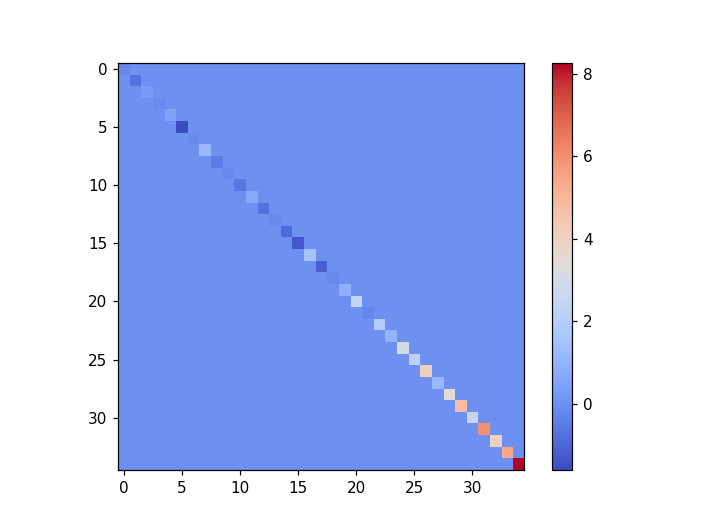

In [93]:
plt.imshow(h0, cmap='coolwarm')
plt.colorbar()

In [246]:
h1 = h0 + 0.1 * (pmat@pmat)

<IPython.core.display.Javascript object>


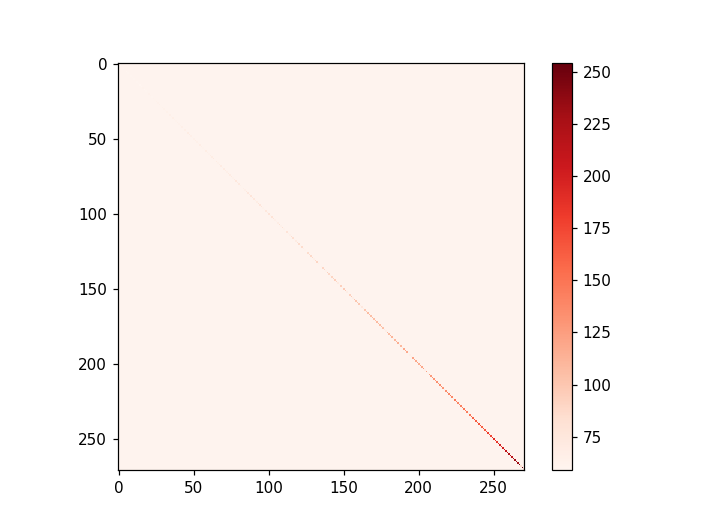

In [247]:
plt.imshow(h1, cmap='Reds')
plt.colorbar()

In [102]:
from scipy.linalg import eigvals

In [107]:
eigvals(h1) - df_1["energy"]

array([  2.98118962+0.j,   1.2605725 +0.j,  -0.33916223+0.j,
        -0.53455622+0.j,  -1.89876666+0.j,   0.12152986+0.j,
        -1.79995052+0.j,  -3.66512941+0.j,  -2.43222113+0.j,
        -2.86166201+0.j,  -2.61389038+0.j,  -4.22831808+0.j,
        -6.32560418+0.j,  -3.74384896+0.j,  -5.86671678+0.j,
        -2.94333801+0.j,  -5.88683986+0.j,  -3.31462447+0.j,
        -4.41707516+0.j,  -5.64335871+0.j,  -9.03347446+0.j,
        -4.7115907 +0.j,  -7.08995138+0.j,  -7.42030393+0.j,
        -9.13691811+0.j,  -8.47520827+0.j, -10.10678272+0.j,
        -7.08068094+0.j,  -9.22927316+0.j, -10.32450265+0.j,
        -8.19624511+0.j, -11.64141827+0.j,  -9.58870446+0.j,
       -11.01874545+0.j, -13.87536698+0.j])

In [110]:
(df_1["energy"] - E_in(par)).values

array([-0.18920939, -0.7188868 ,  0.27548216, -0.17345809,  0.49333603,
       -1.61015331, -0.15570229,  1.18979343, -0.47758409, -0.15050995,
       -0.58531468,  0.68714047, -0.74751535, -0.15652823, -0.92681157,
       -1.33010029,  1.56305314, -1.11876365, -0.17917188,  0.86716424,
        2.45127178, -0.25803277,  1.92227189,  1.03005043,  2.98811916,
        2.26425001,  4.05802576,  1.13966561,  3.50780449,  4.75544362,
        2.55365246,  6.00514381,  3.9748348 ,  5.39977833,  8.25543871])

In [114]:
eigvals(h0) == (df_1["energy"] - E_in(par)).values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [130]:
(eigvals(h1) - (df_1["energy"] - E_in(par)).values)

array([ 8.4446481 +0.j,  6.72403065+0.j,  5.12429619+0.j,  4.92890177+0.j,
        3.56468994+0.j,  5.58498814+0.j,  3.66350691+0.j,  1.79832606+0.j,
        3.03123664+0.j,  2.6017832 +0.j,  2.84956503+0.j,  1.23513231+0.j,
       -0.86258851+0.j,  1.71958416+0.j, -0.40328567+0.j,  2.51991602+0.j,
       -0.42338694+0.j,  2.14881598+0.j,  1.04634058+0.j, -0.18001225+0.j,
       -3.57003347+0.j,  0.75141407+0.j, -1.6449753 +0.j, -1.95686033+0.j,
       -3.7034259 +0.j, -3.01176378+0.j, -4.64333881+0.j, -1.61724699+0.j,
       -3.765835  +0.j, -4.93630975+0.j, -2.73281923+0.j, -6.17853066+0.j,
       -4.12533333+0.j, -5.55545859+0.j, -8.41196016+0.j])

In [131]:
ee = eigvals(h1)

In [132]:
ee.sort()

In [133]:
ee - (df_1["energy"] - E_in(par)).values

array([-1.42089447e+00+0.j, -6.11210441e-01+0.j, -1.39424385e+00+0.j,
       -7.53351810e-01+0.j, -1.24084979e+00+0.j,  8.94846575e-01+0.j,
       -4.29610764e-01+0.j, -1.66737482e+00+0.j,  2.19553586e-01+0.j,
       -3.03561763e-02+0.j,  4.06147915e-01+0.j, -8.60527318e-01+0.j,
        5.90993903e-01+0.j,  8.47978710e-04+0.j,  7.76313043e-01+0.j,
        1.60739689e+00+0.j, -1.06967184e+00+0.j,  1.80591564e+00+0.j,
        1.04634058e+00+0.j,  1.62888083e-01+0.j, -1.31160558e+00+0.j,
        1.44784850e+00+0.j, -3.59215966e-01+0.j,  8.92222358e-01+0.j,
       -7.23868811e-01+0.j,  1.87023236e-01+0.j, -1.50437321e+00+0.j,
        1.84845389e+00+0.j,  1.21634977e-07+0.j, -7.80608791e-01+0.j,
        1.50437351e+00+0.j, -1.24970013e+00+0.j,  1.42494354e+00+0.j,
        6.05365523e-01+0.j,  5.22812726e-09+0.j])

# Try full diag the whole cache

In [12]:
num_states = len(df)

pmat = np.empty((num_states, num_states), dtype=float)

for i in range(num_states):
    print("%s/%s " %(i, num_states), end=" ")
    ri = df.iloc[i, :].to_dict()
    for j in range(num_states):
        rj = df.iloc[j, :].to_dict()
        pmat[i, j] =  mx2.fPf(ri, rj, par)

0/271  1/271  2/271  3/271  4/271  5/271  6/271  7/271  8/271  9/271  10/271  11/271  12/271  13/271  14/271  15/271  16/271  17/271  18/271  19/271  20/271  21/271  22/271  23/271  24/271  25/271  26/271  27/271  28/271  29/271  30/271  31/271  32/271  33/271  34/271  35/271  36/271  37/271  38/271  39/271  40/271  41/271  42/271  43/271  44/271  45/271  46/271  47/271  48/271  49/271  50/271  51/271  52/271  53/271  54/271  55/271  56/271  57/271  58/271  59/271  60/271  61/271  62/271  63/271  64/271  65/271  66/271  67/271  68/271  69/271  70/271  71/271  72/271  73/271  74/271  75/271  76/271  77/271  78/271  79/271  80/271  81/271  82/271  83/271  84/271  85/271  86/271  87/271  88/271  89/271  90/271  91/271  92/271  93/271  94/271  95/271  96/271  97/271  98/271  99/271  100/271  101/271  102/271  103/271  104/271  105/271  106/271  107/271  108/271  109/271  110/271  111/271  112/271  113/271  114/271  115/271  116/271  117/271  118/271  119/271  120/271  121/271  122/271  123

In [13]:
np.savez("fPf_N7.npz")

In [14]:
h0 = np.diag(df["energy"].values - E_in(par))

In [27]:
lmbda = -0.1
h = h0 + lmbda * (pmat@pmat)

In [28]:
ee = linalg.eigvals(h)

In [29]:
ee = ee.real

In [30]:
np.sort(ee)

array([-1.98805063e+00, -1.64805364e+00, -1.35041762e+00, -1.08236067e+00,
       -1.01435956e+00, -9.98827132e-01, -8.42083467e-01, -7.00244192e-01,
       -6.38095062e-01, -5.54238909e-01, -5.40830396e-01, -5.21770899e-01,
       -4.21098293e-01, -3.31757120e-01, -2.76005809e-01, -2.55165474e-01,
       -2.30562512e-01, -2.06270911e-01, -1.36970221e-01,  9.11309109e-02,
        1.55514352e-01,  3.48578319e-01,  4.72980531e-01,  5.66320901e-01,
        6.32154554e-01,  6.58395133e-01,  8.15572813e-01,  8.94893165e-01,
        1.02966839e+00,  1.06161679e+00,  1.06323065e+00,  1.19015820e+00,
        1.28355285e+00,  1.33667858e+00,  1.34748109e+00,  1.38275377e+00,
        1.43981777e+00,  1.52857146e+00,  1.60795680e+00,  1.85067170e+00,
        1.88136383e+00,  1.94406178e+00,  2.07292948e+00,  2.22270585e+00,
        2.25354524e+00,  2.26348268e+00,  2.35947183e+00,  2.42609910e+00,
        2.44807020e+00,  2.61065496e+00,  2.66012266e+00,  2.67025120e+00,
        2.75835713e+00,  

In [31]:
ee_cut = np.sort(ee[ee < 2*E_in(par) ])
ee_cut

array([-1.98805063, -1.64805364, -1.35041762, -1.08236067, -1.01435956,
       -0.99882713, -0.84208347, -0.70024419, -0.63809506, -0.55423891,
       -0.5408304 , -0.5217709 , -0.42109829, -0.33175712, -0.27600581,
       -0.25516547, -0.23056251, -0.20627091, -0.13697022,  0.09113091,
        0.15551435,  0.34857832,  0.47298053,  0.5663209 ,  0.63215455,
        0.65839513,  0.81557281,  0.89489316,  1.02966839,  1.06161679,
        1.06323065,  1.1901582 ,  1.28355285,  1.33667858,  1.34748109,
        1.38275377,  1.43981777,  1.52857146,  1.6079568 ,  1.8506717 ,
        1.88136383,  1.94406178,  2.07292948,  2.22270585,  2.25354524,
        2.26348268,  2.35947183,  2.4260991 ,  2.4480702 ,  2.61065496,
        2.66012266,  2.6702512 ,  2.75835713,  2.8998526 ,  3.04511806,
        3.08996522,  3.11570716,  3.16161081,  3.255249  ,  3.30856603,
        3.34626323,  3.44658281,  3.48987513,  3.58251955,  3.73964941,
        3.74151268,  3.83801889,  3.93249254,  4.02666418,  4.06

In [32]:
ee_unpert = np.sort(np.diag(h0))[:ee_cut.size]

In [33]:
ee_cut - ee_unpert

array([-0.37789732, -0.31795334, -0.23165397, -0.1555491 , -0.23576868,
       -0.25131178, -0.12319667, -0.11492951, -0.16051097, -0.14655167,
       -0.28279763, -0.33256151, -0.24192642, -0.15829903, -0.11947757,
       -0.09946318, -0.08005256, -0.15684375, -0.24273397, -0.18435125,
       -0.16253787, -0.14475771, -0.21415994, -0.29654737, -0.23500969,
       -0.37165529, -0.3240928 , -0.29490027, -0.17894141, -0.36557393,
       -0.37523448, -0.25222928, -0.17539126, -0.12325281, -0.11757367,
       -0.09450907, -0.12323537, -0.22981006, -0.31431509, -0.21162446,
       -0.22908806, -0.32018823, -0.22573704, -0.22856593, -0.22837281,
       -0.29016978, -0.2959126 , -0.23784386, -0.38735717, -0.3774642 ,
       -0.35397655, -0.41242685, -0.34906193, -0.22885638, -0.35967599,
       -0.32164797, -0.31579877, -0.27533381, -0.19481439, -0.1775745 ,
       -0.16154126, -0.09035343, -0.4084836 , -0.39231526, -0.29711131,
       -0.31651308, -0.24324087, -0.27484814, -0.22372239, -0.19

In [ ]:
ee_cut - ee_unpert

In [24]:
from numpy.linalg import cond

In [25]:
cond(h)

6371.60843945848

<IPython.core.display.Javascript object>


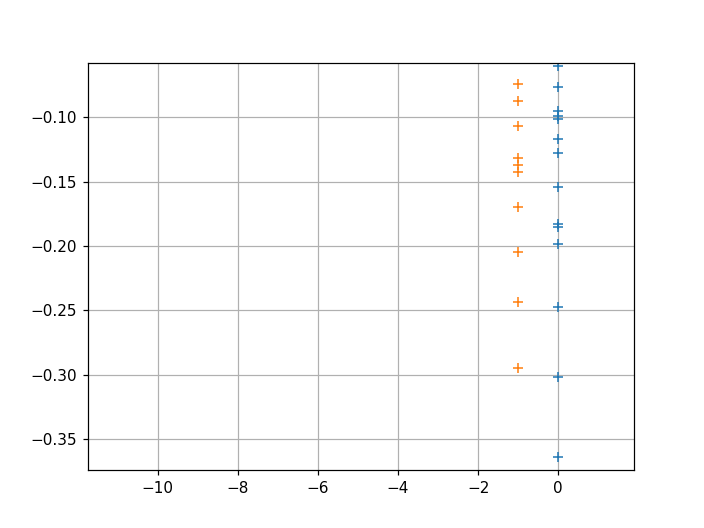

In [34]:
plt.plot([0]*len(ee_cut), ee_cut/E_in(par), '+')
plt.plot([-1]*len(ee_unpert), ee_unpert / E_in(par), "+")
plt.gca().set_xlim([-150, 10])
plt.grid(True)

<IPython.core.display.Javascript object>


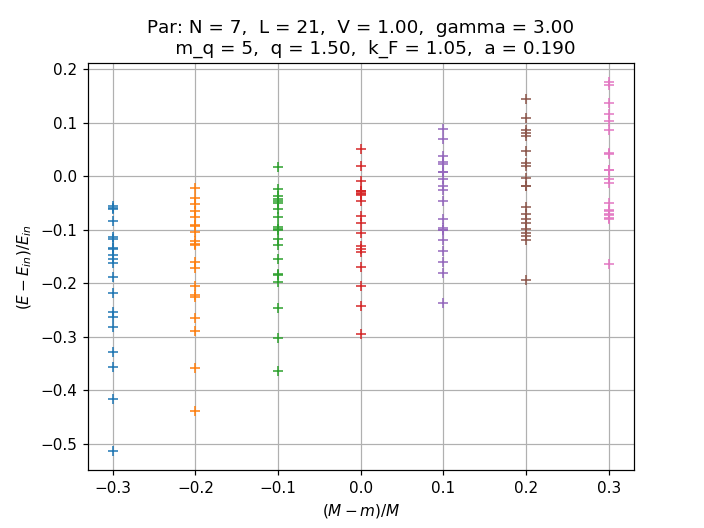

Text(0.5, 1.0, 'Par: N = 7,  L = 21,  V = 1.00,  gamma = 3.00\n     m_q = 5,  q = 1.50,  k_F = 1.05,  a = 0.190')

In [42]:
nst = 20
fig, ax = plt.subplots()

for lmbda in [-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3]:
    h = h0 + lmbda * (pmat@pmat)
    ee = linalg.eigvals(h)
    ee = ee.real
    ee.sort()
    ax.plot([lmbda]*nst, ee[:nst]/E_in(par), '+')

plt.grid(True)
plt.ylabel(r'$(E-E_{in}) / E_{in}$')
plt.xlabel(r'$(M - m) / M$')
plt.title(long_print(par))


In [41]:
from mcba.models.impurity.ph_param import long_print
long_print(par)

'Par: N = 7,  L = 21,  V = 1.00,  gamma = 3.00\n     m_q = 5,  q = 1.50,  k_F = 1.05,  a = 0.190'

<IPython.core.display.Javascript object>


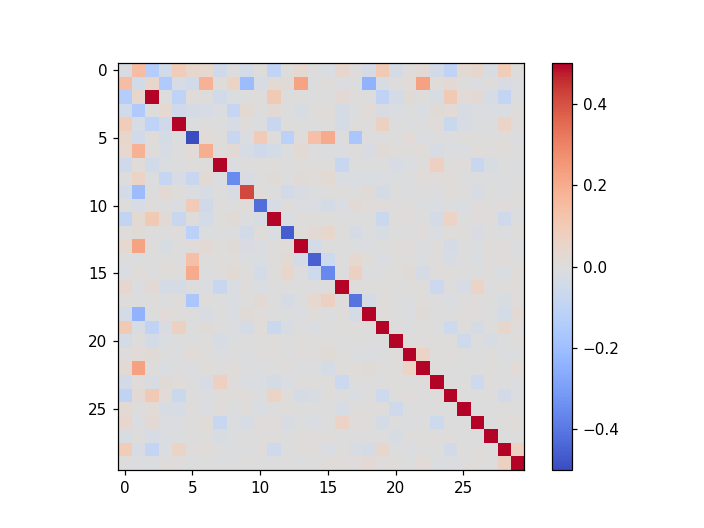

In [56]:
plt.imshow(h[:30, :30], cmap='coolwarm', vmin=-0.5, vmax=0.5)
plt.colorbar()

# $E(q)$

In [7]:
for m in range(8):
    par = Par(N=7, L=21, m_q=m)
    print(m, initial_q(par) / k_F(par))

0 0.0
1 0.28571428571428575
2 0.5714285714285715
3 0.8571428571428572
4 1.142857142857143
5 1.4285714285714286
6 1.7142857142857144
7 2.0


In [9]:
for m in range(8):
    par = Par(N=7, L=21, m_q=m)
    model = SingleImpurity(par)
    walker = Walker(model,
                    db_fname='./data_N15/N7mq%s.sqlite' % m,
                    threshold=0.99) 
    walker.walk()


 *** checkpointing, do NOT terminate...done

***************** sweeps =  42 	( 8  steps each)
Par: N = 7,  L = 21,  V = 1.00,  gamma = 3.00
     m_q = 0,  q = 0.00,  k_F = 1.05,  a = 0.190
total cnf count =  50 rcache size =  0
\sum |<FS|fq>|^2 = 0.9666
\sum  <fq | P_up | fq> = 0.001146
self.fs_pairs =  fsPairs(h=[-3, 3], p=[-15, 12])
addr/acpt: 
	 create/annihilate_pair:  0.45 / 0.033
	 move_fs_hole:  0.048 / 0.0089
	 move_fs_particle:  0.068 / 0.012
	 umklapp_hole:  0.12 / 0.003
	 umkl_scatter:  0.12 / 0.045
	 scatter_hp:  0.068 / 0.039
	 scatter_pp:  0.14 / 0.051
	 scatter_hh:  0.06 / 0.021



 *** BASolverTwoStepTab: fsolve failed w/ fs_pairs = fsPairs(h=[-4, 3], p=[-8, 7]),  c0 = 0 
                    full output: ier = 5, mesg = The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations., infodict = {'r': array([4.4408921e-16]), 'fvec': 1.7763568394002505e-15, 'qtf': array([-1.77635684e-15]), 'nfev': 15, 'fjac': array([[-1.]])}, lh

\sum  <fq | P_up | fq> = 0.5595
self.fs_pairs =  fsPairs(h=[3], p=[4])
addr/acpt: 
	 create/annihilate_pair:  0.43 / 0.13
	 move_fs_hole:  0.24 / 0.074
	 move_fs_particle:  0.23 / 0.06
	 umklapp_hole:  0.23 / 0.074
	 umkl_scatter:  0.13 / 0.067
	 scatter_hp:  0.088 / 0.061
	 scatter_pp:  0.13 / 0.046
	 scatter_hh:  0.046 / 0.013



 *** checkpointing, do NOT terminate...done

***************** sweeps =  126 	( 8  steps each)
Par: N = 7,  L = 21,  V = 1.00,  gamma = 3.00
     m_q = 3,  q = 0.90,  k_F = 1.05,  a = 0.190
total cnf count =  202 rcache size =  0
\sum |<FS|fq>|^2 = 0.9931
\sum  <fq | P_up | fq> = 0.5607
self.fs_pairs =  fsPairs(h=[2, -4], p=[-5, 7])
addr/acpt: 
	 create/annihilate_pair:  0.37 / 0.11
	 move_fs_hole:  0.28 / 0.079
	 move_fs_particle:  0.28 / 0.08
	 umklapp_hole:  0.31 / 0.09
	 umkl_scatter:  0.21 / 0.091
	 scatter_hp:  0.14 / 0.089
	 scatter_pp:  0.25 / 0.1
	 scatter_hh:  0.087 / 0.024



 *** checkpointing, do NOT terminate...done

FINALLY,
  total distinct c

In [29]:
mrs = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]
mqs = list(range(8))
lst_res = []

for m in mqs:
    # read in the DB
    db_fname = "./data_N15/N7mq%s.sqlite" % m
    handle, = db.get_handles(db_fname)
    par = db.get_param(handle)

    lst = list(dict(_) for _ in db.row_iterator(handle) if _["c"] != np.inf)
    for x in lst:
        x['energy'] = energy(x, par)

    lst_1 = [mx2._preprocess_roots(x, par) for x in lst] 
    
    df = pd.DataFrame(lst)
    df["FSfq**2"] = df["FSfq"]**2
    df = df.sort_values("FSfq**2", ascending=False)
    
    # Build the <f|P\f> matrix
    num_states = len(df)

    pmat = np.empty((num_states, num_states), dtype=float)

    for i in range(num_states):
        print("%s/%s " %(i, num_states), end=" ")
        ri = df.iloc[i, :].to_dict()
        for j in range(num_states):
            rj = df.iloc[j, :].to_dict()
            pmat[i, j] =  mx2.fPf(ri, rj, par)
    
    np.savez_compressed("./data_N15/fPf_N7mq%s.npz" % m, pmat)
    
    # Build and diag H1
    p2mat = pmat @ pmat
    
    h0 = np.diag(df["energy"])
    for mr in mrs:
        factor = mr - 1. 
        h1 = h0 + factor*p2mat
        e1 = linalg.eigvals(h1)
        e1 = e1.real
        e1.sort()
        assert e1[0] == e1.min()
    
        dct = {"mr" : mr,
               "m_q" : m,
               "par" : par,
               "Q": initial_q(par) / k_F(par),
               "E_gs" : e1[0] / E_F(par),
               "E_1" : e1[1] / E_F(par),
              }
        lst_res.append(dct)
    #e_gs.append(e1.min() / E_F(par))
    #qs.append(initial_q(par) / k_F(par))
    print("\n>>>>>> ", m, qs[-1], e_gs[-1])
    
df_gs = pd.DataFrame(lst_res)

0/471  1/471  2/471  3/471  4/471  5/471  6/471  7/471  8/471  9/471  10/471  11/471  12/471  13/471  14/471  15/471  16/471  17/471  18/471  19/471  20/471  21/471  22/471  23/471  24/471  25/471  26/471  27/471  28/471  29/471  30/471  31/471  32/471  33/471  34/471  35/471  36/471  37/471  38/471  39/471  40/471  41/471  42/471  43/471  44/471  45/471  46/471  47/471  48/471  49/471  50/471  51/471  52/471  53/471  54/471  55/471  56/471  57/471  58/471  59/471  60/471  61/471  62/471  63/471  64/471  65/471  66/471  67/471  68/471  69/471  70/471  71/471  72/471  73/471  74/471  75/471  76/471  77/471  78/471  79/471  80/471  81/471  82/471  83/471  84/471  85/471  86/471  87/471  88/471  89/471  90/471  91/471  92/471  93/471  94/471  95/471  96/471  97/471  98/471  99/471  100/471  101/471  102/471  103/471  104/471  105/471  106/471  107/471  108/471  109/471  110/471  111/471  112/471  113/471  114/471  115/471  116/471  117/471  118/471  119/471  120/471  121/471  122/471  123

0/201  1/201  2/201  3/201  4/201  5/201  6/201  7/201  8/201  9/201  10/201  11/201  12/201  13/201  14/201  15/201  16/201  17/201  18/201  19/201  20/201  21/201  22/201  23/201  24/201  25/201  26/201  27/201  28/201  29/201  30/201  31/201  32/201  33/201  34/201  35/201  36/201  37/201  38/201  39/201  40/201  41/201  42/201  43/201  44/201  45/201  46/201  47/201  48/201  49/201  50/201  51/201  52/201  53/201  54/201  55/201  56/201  57/201  58/201  59/201  60/201  61/201  62/201  63/201  64/201  65/201  66/201  67/201  68/201  69/201  70/201  71/201  72/201  73/201  74/201  75/201  76/201  77/201  78/201  79/201  80/201  81/201  82/201  83/201  84/201  85/201  86/201  87/201  88/201  89/201  90/201  91/201  92/201  93/201  94/201  95/201  96/201  97/201  98/201  99/201  100/201  101/201  102/201  103/201  104/201  105/201  106/201  107/201  108/201  109/201  110/201  111/201  112/201  113/201  114/201  115/201  116/201  117/201  118/201  119/201  120/201  121/201  122/201  123

In [11]:
np.array([1, 2, 3]).min()

1

In [17]:
e_gs

[2.7275117378192193,
 2.8034142439531755,
 3.0309366737638204,
 3.388923754875012,
 3.7758805387158834,
 4.013090079320582,
 4.060527365805397,
 4.062495096423086]

<IPython.core.display.Javascript object>


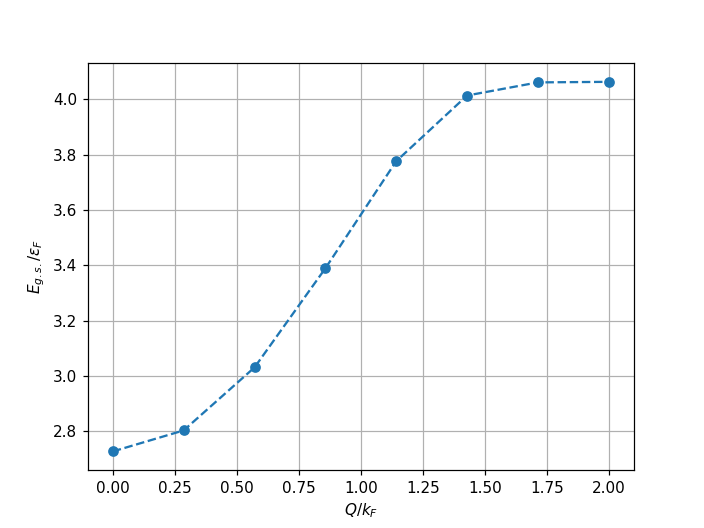

In [25]:
plt.plot(qs, e_gs, 'o--')
plt.xlabel(r'$Q/k_F$')
plt.ylabel(r'$E_{g.s.} / \epsilon_F$')
plt.grid(True)

In [26]:
a = np.array([4, 2, 2, 1]) 
a.sort()
a

array([1, 2, 2, 4])

In [32]:
df_gs.tail()

,E_1,E_gs,Q,m_q,mr,par
83,4.081099,3.677754,2.0,7,1.1,"(7, 21, 1.0, 7)"
84,4.377757,4.062495,2.0,7,1.2,"(7, 21, 1.0, 7)"
85,4.680401,4.432637,2.0,7,1.3,"(7, 21, 1.0, 7)"
86,5.001819,4.768556,2.0,7,1.4,"(7, 21, 1.0, 7)"
87,5.346832,5.049092,2.0,7,1.5,"(7, 21, 1.0, 7)"


In [39]:
df_grp = df_gs.groupby("mr")

'mr'

In [41]:
for x, y in df_gs.groupby("mr"):
    print(x, type(x))

0.5 <class 'float'>
0.6 <class 'float'>
0.7 <class 'float'>
0.8 <class 'float'>
0.9 <class 'float'>
1.0 <class 'float'>
1.1 <class 'float'>
1.2 <class 'float'>
1.3 <class 'float'>
1.4 <class 'float'>
1.5 <class 'float'>


<IPython.core.display.Javascript object>


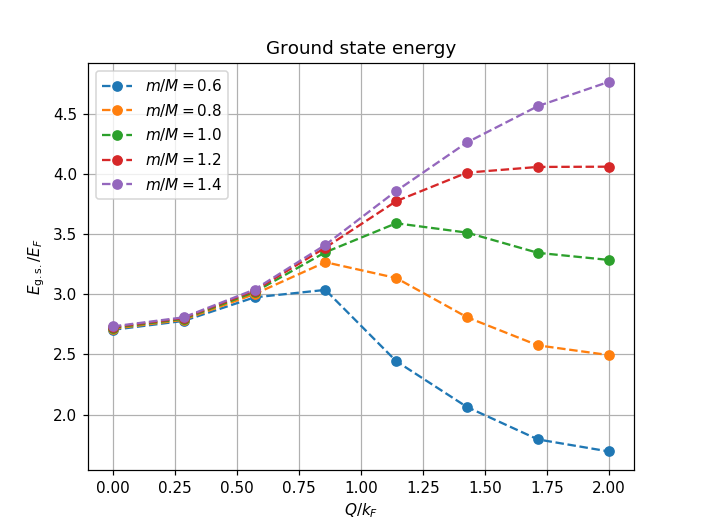

In [63]:
df_grp = df_gs.groupby("mr")
for m in mrs[1::2]:
    grp = df_grp.get_group(m)
    plt.plot(grp["Q"], grp["E_gs"], 'o--', label=r'$m/M=%s$' % m)
    
plt.legend(loc='best')
plt.xlabel(r'$Q / k_F$')
plt.ylabel(r'$E_\mathrm{g.s.} / E_F$')
plt.title('Ground state energy')
plt.grid(True)

<IPython.core.display.Javascript object>


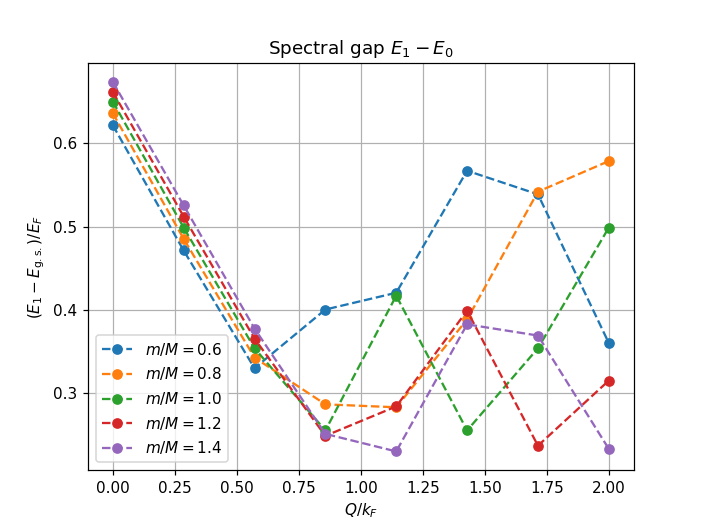

In [66]:
df_grp = df_gs.groupby("mr")
for m in mrs[1::2]:
    grp = df_grp.get_group(m)
    plt.plot(grp["Q"], grp["E_1"] - grp['E_gs'], 'o--', label=r'$m/M=%s$' % m)

plt.legend(loc='best')
plt.xlabel(r'$Q / k_F$')
plt.ylabel(r'$(E_1 - E_\mathrm{g.s.}) / E_F$')
plt.title(r"Spectral gap $E_1 - E_0$")
plt.grid(True)